# Dati Covid-19

In [1]:
import sys, glob
import pandas as pd
import numpy as np
from miscellanea import adatta_nome, importa_abitanti

### Dati nazionali, regionali, provinciali

Fonte dati: [Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile](https://github.com/pcm-dpc)

Import dati nazionali e regionali

In [5]:
dataset = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
df = pd.read_csv(dataset)
temp = df[['data','nuovi_positivi']].groupby(by='data').sum()
ita = pd.Series(data=temp.nuovi_positivi, index=pd.to_datetime(temp.index))

ita_abitanti = 59_641_488 # Fonte https://www.tuttitalia.it/regioni/popolazione/

Emilia Romagna

In [6]:
temp = df[df.denominazione_regione=='Emilia-Romagna']
emr = pd.Series(data=temp.nuovi_positivi.values, index=pd.to_datetime(temp.data))

emr_abitanti = 4_464_119 # Fonte https://www.tuttitalia.it/regioni/popolazione/

Import dati provinciali

In [7]:
dataset = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
df = pd.read_csv(dataset)
temp = df[df.denominazione_provincia=='Modena'][['data','totale_casi']]
mo = pd.Series(data=temp.totale_casi.diff().values.astype(int)[1:], index=pd.to_datetime(temp.data[1:]))
mo_abitanti = 707_119 # Fonte https://www.tuttitalia.it/emilia-romagna/provincia-di-modena/

### Dati provincia di Modena - dettaglio comuni

Import dei dati dai file con i nuovi positivi dal report dell'AUSL di Modena (recuperati dalle pagine di [sulpanaro.net](https://www.sulpanaro.net/))

In [8]:
comuni = glob.glob('giornaliero/*.txt')

dlist=[]   # lista di dictionary che conterranno i dati dei comuni
daylist=[] # lista dei giorni (presi dal nome del file)
for file in comuni:
    with open(file) as f:
        d = {}
        for l in f.readlines():
            campi = l.rstrip().split(' ')
            
            # salta le linee vuote
            if len(campi[-1])==0:
                continue
            
            # se l'ultimo campo è un numero, associa quel numero alla stringa precedente (Comune)
            # altrimenti prendi tutta la linea come Comune e associa il nr 0
            if campi[-1].isdigit():
                comune = ' '.join(campi[:-1])
                nuovi  = campi[-1]
            else:
                comune = ' '.join(campi)
                nuovi  = 0
            
            comune = comune.rstrip().lstrip()
            comune = adatta_nome(comune)
            d[comune]=nuovi
            
        dlist.append(d)
        daylist.append(file.split('_')[-1].split('.')[0])

# crea dataframe
dayindex = pd.to_datetime(daylist, format='%d-%m-%Y')
df = pd.DataFrame(data=dlist, index=dayindex).sort_index()
df = df.fillna(0).astype(int)


Check sul contenuto del dataframe

In [9]:
df.tail()
df.columns

Index(['Castelfranco E.', 'Finale Emilia', 'Fiorano M.', 'Formigine',
       'Mirandola', 'Modena', 'Montese', 'Pievepelago', 'Fuori provincia',
       'Bastiglia', 'Bomporto', 'Campogalliano', 'Camposanto', 'Carpi',
       'Castelnuovo R.', 'Castelvetro', 'Cavezzo', 'Concordia', 'Fanano',
       'Fiumalbo', 'Frassinoro', 'Guiglia', 'Lama Mocogno', 'Maranello',
       'Marano', 'Medolla', 'Montecreto', 'Montefiorino', 'Nonantola', 'Novi',
       'Palagano', 'Pavullo', 'Prignano', 'Polinago', 'Ravarino', 'Riolunato',
       'San Cesario S/P', 'San Felice S/P', 'San Possidonio', 'San Prospero',
       'Sassuolo', 'Savignano S/P', 'Serramazzoni', 'Sestola', 'Soliera',
       'Spilamberto', 'Vignola', 'Zocca', 'TOTALE'],
      dtype='object')

Metti in evidenza date mancanti (per recuperare i dati man mano) isolando le date che distano più di un giorno dalla precedente

In [10]:
giorni = pd.Series(df.index, index=df.index).diff()
for g in zip(giorni[giorni>pd.to_timedelta('1 day')].index, giorni[giorni>pd.to_timedelta('1 day')].values):
    print(f"{g[0].date()} --> mancano {g[1]/1e9 /3600/24 - 1 } giorni precedenti")

2020-09-20 --> mancano 4 giorni precedenti
2020-09-23 --> mancano 1 giorni precedenti
2020-09-26 --> mancano 2 giorni precedenti
2020-10-03 --> mancano 5 giorni precedenti
2020-10-06 --> mancano 1 giorni precedenti
2020-10-11 --> mancano 3 giorni precedenti
2020-10-14 --> mancano 1 giorni precedenti
2020-10-26 --> mancano 8 giorni precedenti
2020-11-02 --> mancano 6 giorni precedenti
2020-11-09 --> mancano 6 giorni precedenti
2020-11-16 --> mancano 5 giorni precedenti
2020-11-27 --> mancano 1 giorni precedenti
2020-12-05 --> mancano 2 giorni precedenti
2020-12-07 --> mancano 1 giorni precedenti
2020-12-11 --> mancano 3 giorni precedenti
2020-12-15 --> mancano 1 giorni precedenti
2020-12-22 --> mancano 1 giorni precedenti
2020-12-24 --> mancano 1 giorni precedenti
2020-12-27 --> mancano 1 giorni precedenti
2020-12-29 --> mancano 1 giorni precedenti
2020-12-31 --> mancano 1 giorni precedenti
2021-01-08 --> mancano 2 giorni precedenti
2021-02-09 --> mancano 1 giorni precedenti


## Nuovi positivi

Leggi i dati degli abitanti dei comuni nella provincia di Modena da [qui](https://www.tuttitalia.it/emilia-romagna/provincia-di-modena/70-comuni/popolazione/) (aggiornato a 31/12/2019 - dati ISTAT)

In [11]:
abitanti = importa_abitanti('abitanti_provincia_di_Modena.txt')

Aggiungi abitanti provincia, regione, nazione

In [12]:
abitanti['Emilia Romagna'] = emr_abitanti
abitanti['Italia'] = ita_abitanti
abitanti['Provincia MO'] = mo_abitanti

Timeline su intervallo 7gg.

In [13]:
roll = df.rolling(7, center=True).sum()
ita_roll = ita.rolling(7, center=True).sum()
emr_roll = emr.rolling(7, center=True).sum()
mo_roll = mo.rolling(7, center=True).sum()

## Salva report dati

Report in diversi formati per altri usi (<font color=red>da aggiornare ogni giorno</font>).

Nuovi positivi divisi per comune (tutte le date disponibili) - **EXCEL**

In [14]:
df.to_excel('report_vari/nuovi_positivi_comuni_MO.xlsx')
roll.to_excel('report_vari/nuovi_positivi_rolling7gg_comuni_MO.xlsx')

File separati per comune con dati positivi, somma mobile 7gg. e stessa somma rapportata a 100mila abitanti - **EXCEL** e **CSV**

In [15]:
lista_output = [ comune for comune in df.columns if (comune!='Fuori provincia')&(comune!='TOTALE') ]

for comune in lista_output :
    nome_file = comune.replace(' ','').replace('.','').replace('/','') # crea nomi di file semplici
    temp_df = pd.concat((df[comune], roll[comune], roll[comune]/abitanti[comune]*100000), axis=1)
    temp_df.columns = ['nuovi pos.', 'somma mobile 7gg.', 'somma mobile 7gg. per 100mila abitanti']
    temp_df.to_excel('report_vari/comuni/' + nome_file + '.xlsx')
    temp_df.to_csv('report_vari/comuni/' + nome_file + '.csv')

## Grafici

### Nonantola

Comuni con cui confrontare

In [33]:
lista_comuni = ['Carpi',
    'Sassuolo',
    'Formigine',
    'Castelfranco E.',
    'Vignola',
    'Mirandola',
    'Pavullo',
    'Maranello',
    'Fiorano M.',
#     'Nonantola',
    'Soliera',
    'Finale Emilia',
    'Castelnuovo R.',
    'Spilamberto',
    'Castelvetro',
    'San Felice S/P',
    'Bomporto',
    'Novi']
# per vedere elenco completo scommentare qui
#sorted(list(df.columns))

Dal 1 gennaio in poi

In [34]:
range_temporale = '2021-01'

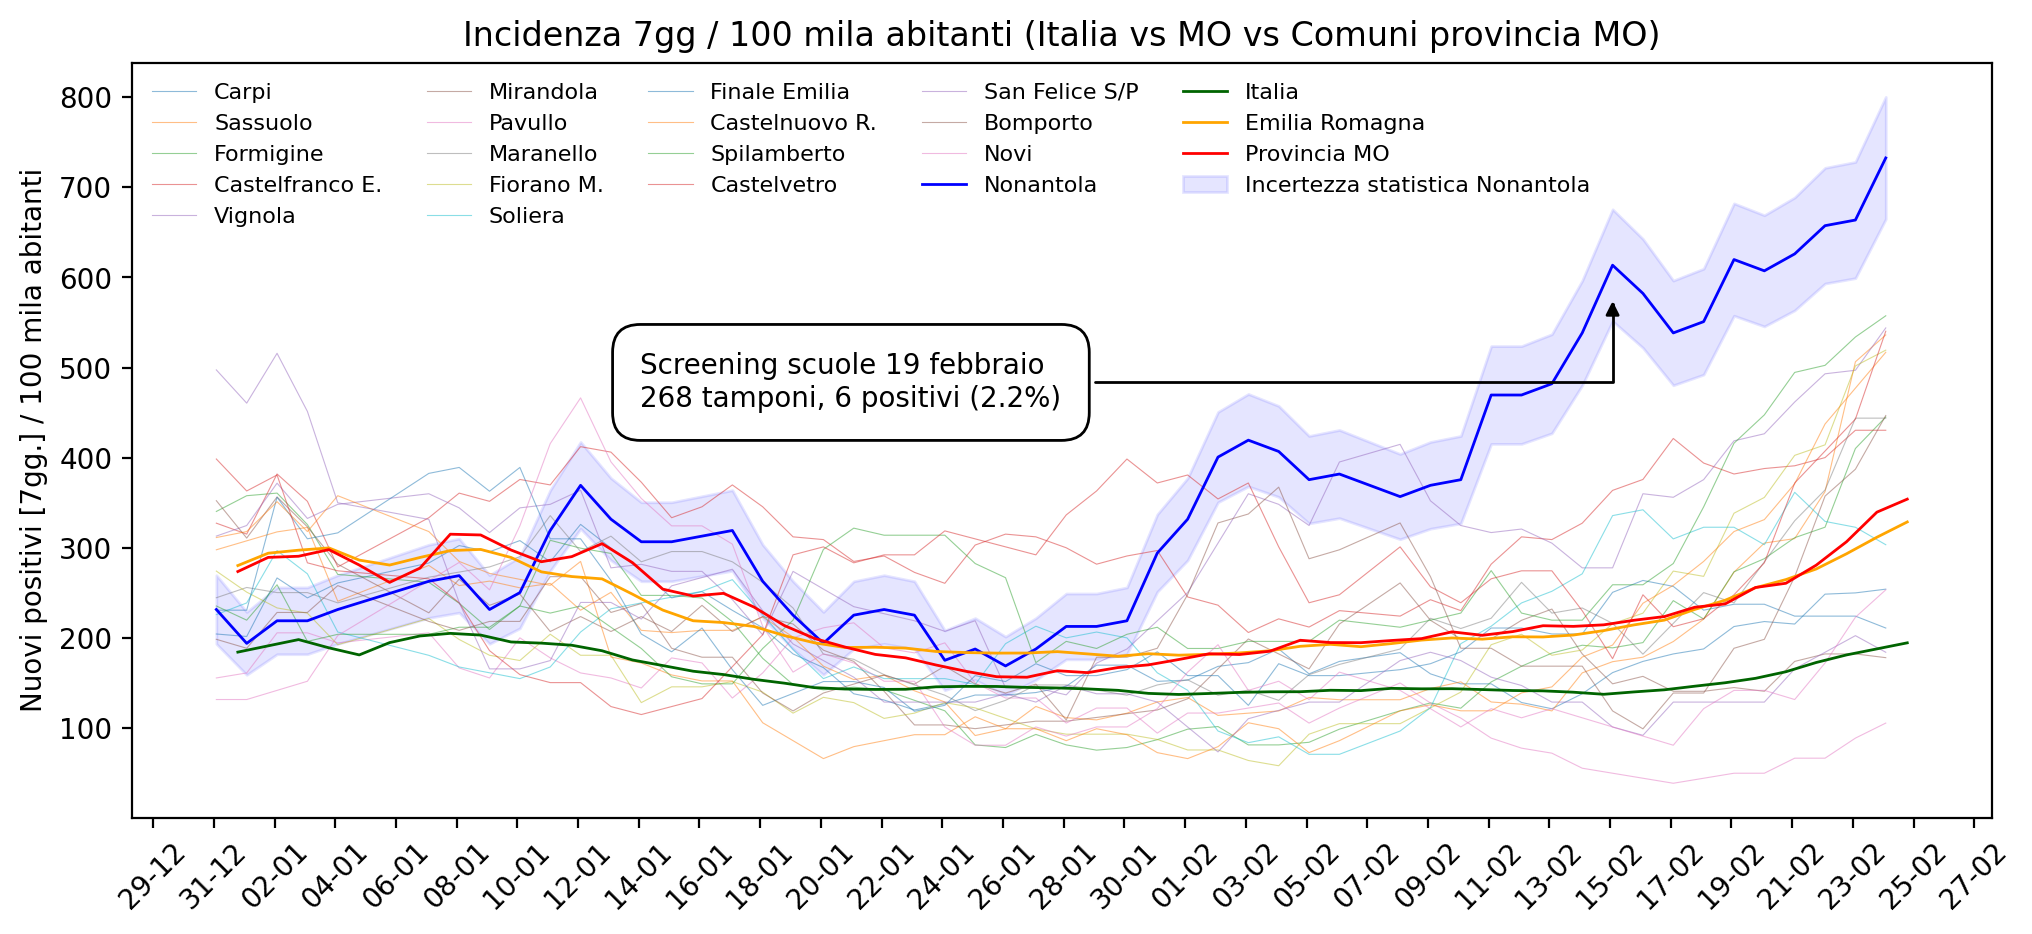

In [39]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

#plt.style.use('dark_background')
plt.style.use('fast')
# plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-deep')
# plt.style.use('seaborn-dark-palette')

fig, ax = plt.subplots(figsize=(12,5), dpi=200)

xfmt = mdates.DateFormatter('%d-%m')
xloc = mdates.HourLocator(interval=24*2)
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis.set_major_locator(xloc)
ax.tick_params(axis='x', rotation=45)

ax.set_title('Incidenza 7gg / 100 mila abitanti (Italia vs MO vs Comuni provincia MO)')
ax.set_ylabel('Nuovi positivi [7gg.] / 100 mila abitanti')

for k in lista_comuni:
    toplot = roll[k]/abitanti[k]*100000
    ax.plot(toplot[range_temporale:], 
#              drawstyle='steps',
            alpha=0.5, lw=0.4, label=k
           )
    
# Nonantola
toplot = roll['Nonantola']/abitanti['Nonantola']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=1, color='blue', label='Nonantola')

# # Soliera
# toplot = roll['Soliera']/abitanti['Soliera']*100000
# ax.plot(toplot[range_temporale:], alpha=1, lw=3, color='Magenta', label='Soliera')

# Nonantola, banda incert. statistica    
toplot_inf = (roll['Nonantola'] - np.sqrt(roll['Nonantola'])) / abitanti['Nonantola']*100000
toplot_sup = (roll['Nonantola'] + np.sqrt(roll['Nonantola'])) / abitanti['Nonantola']*100000
ax.fill_between(toplot_inf[range_temporale:].index, 
                toplot_sup[range_temporale:],
                toplot_inf[range_temporale:],
                alpha=0.1, color='blue',
               label='Incertezza statistica Nonantola')

# Screening scuole del 19 febbraio --> impattano dal giorno 19 - 3 = 16
propfrecce = dict(arrowstyle='-|>', color='k', connectionstyle = "angle,angleA=0,angleB=90,rad=0")

ax.annotate('Screening scuole 19 febbraio\n268 tamponi, 6 positivi (2.2%)', (pd.to_datetime('2021-02-16'), 580), xytext=(-350, -40), textcoords='offset points', 
            arrowprops=propfrecce,
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'),
               color='k')

## Nazione, Regione, Provincia
toplot = ita_roll/abitanti['Italia']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=1, color='darkgreen', label='Italia')
toplot = emr_roll/abitanti['Emilia Romagna']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=1, color='orange', label='Emilia Romagna')
toplot = mo_roll/abitanti['Provincia MO']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=1, color='red', label='Provincia MO')

plt.legend(ncol=5, fontsize=8, frameon=False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=8)

plt.show()
fig.savefig('Nonantola.png')
fig.savefig('Nonantola.pdf')